### Trying to make glass distributions to improve computation time

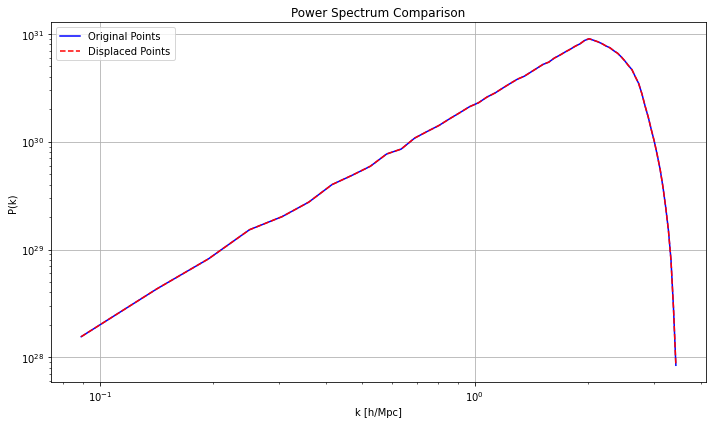

In [20]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import matplotlib.pyplot as plt

def compute_zeldovich_displacements(grid_size, box_size, power_spectrum, redshift):
    # (Same as before)
    D_growth = cosmo.scale_factor(redshift)
    k = fftfreq(grid_size, d=box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k, k, k, indexing="ij")
    k2 = kx**2 + ky**2 + kz**2
    k2[k2 == 0] = 1e-10
    delta_k = (np.random.normal(0, 1, (grid_size, grid_size, grid_size)) +
               1j * np.random.normal(0, 1, (grid_size, grid_size, grid_size)))
    delta_k *= np.sqrt(power_spectrum(np.sqrt(k2)))
    displacement_x_k = -1j * kx * delta_k / k2
    displacement_y_k = -1j * ky * delta_k / k2
    displacement_z_k = -1j * kz * delta_k / k2
    displacement_x = np.real(ifftn(displacement_x_k)) * D_growth
    displacement_y = np.real(ifftn(displacement_y_k)) * D_growth
    displacement_z = np.real(ifftn(displacement_z_k)) * D_growth
    displacements = np.stack([displacement_x, displacement_y, displacement_z], axis=0)
    return displacements

def apply_displacements_to_points(points, displacements, box_size):
    # (Same as before)
    grid_size = displacements.shape[1]
    grid_coords = np.linspace(0, box_size, grid_size)
    interpolators = [
        RegularGridInterpolator((grid_coords, grid_coords, grid_coords), displacements[i], bounds_error=False, fill_value=0)
        for i in range(3)
    ]
    interpolated_displacements = np.stack([interp(points) for interp in interpolators], axis=-1)
    displaced_points = points + interpolated_displacements
    return displaced_points

def calculate_power_spectrum(points, box_size, grid_size):
    """
    Calculate the power spectrum of a set of points.

    Parameters:
        points (ndarray): Array of points (N, 3).
        box_size (float): Size of the box in Mpc/h.
        grid_size (int): Number of grid cells along one dimension.

    Returns:
        k (ndarray): Wavenumbers.
        Pk (ndarray): Power spectrum values.
    """
    # Create a 3D density grid
    density_grid, _ = np.histogramdd(points, bins=grid_size, range=[[0, box_size]]*3)
    density_grid -= np.mean(density_grid)  # Subtract mean density
    density_grid /= (np.mean(density_grid)+1e-10)  # Divide by mean density

    # Fourier transform of the density field
    delta_k = fftn(density_grid)
    power_spectrum = np.abs(delta_k)**2

    # Compute k bins and average power spectrum
    grid = fftfreq(grid_size, box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(grid, grid, grid, indexing='ij')
    k = np.sqrt(kx**2 + ky**2 + kz**2).flatten()
    power_spectrum = power_spectrum.flatten()

    k_bins = np.linspace(0, np.max(k), grid_size // 2)
    Pk, _ = np.histogram(k, bins=k_bins, weights=power_spectrum)
    k_avg, _ = np.histogram(k, bins=k_bins, weights=k)

    k_avg = k_avg / np.maximum(np.histogram(k, bins=k_bins)[0], 1) #avoid division by zero
    return k_avg[1:], Pk[1:]  # Exclude the first bin (k=0)

# Parameters
grid_size = 128
box_size = 200.0  # Mpc/h
redshift = 0.5
num_points = 1000000

# Power spectrum function
def example_power_spectrum(k):
    return np.where(k > 0, k**-2, 0)

# Generate random points
random_points = np.random.uniform(0, box_size, (num_points, 3))

# Compute Zel'dovich displacements and apply them
displacements = compute_zeldovich_displacements(grid_size, box_size, example_power_spectrum, redshift)
displaced_points = apply_displacements_to_points(random_points, displacements, box_size)

# Calculate power spectra
k_original, Pk_original = calculate_power_spectrum(random_points, box_size, grid_size)
k_displaced, Pk_displaced = calculate_power_spectrum(displaced_points, box_size, grid_size)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.loglog(k_original, Pk_original, label='Original Points', color='blue')
plt.loglog(k_displaced, Pk_displaced, label='Displaced Points', color='red', linestyle='--')

n_mean = num_points / box_size**3
P_shot = 1 / n_mean
#plt.axhline(P_shot, color='gray', linestyle='--', label='Shot Noise')
#plt.axvline(2, color='gray', linestyle='-')

plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Create a distribution from a field that obeys P(k) = k^4

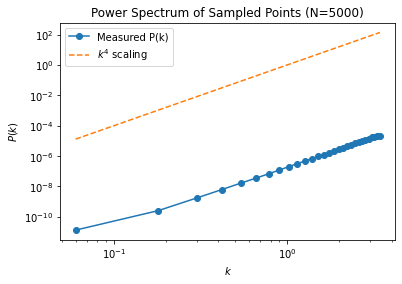

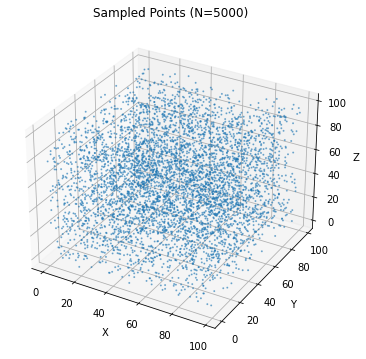

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Grid points per dimension
L = 100.0  # Box size
N_points = 5000  # Desired number of points

# Define k-space grid
k_freq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Convert to physical k
kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1  # Avoid division by zero at k=0

# Generate random phases
random_phases = np.exp(2j * np.pi * np.random.rand(N, N, N))

# Apply power-law P(k) ~ k^4  ->  δ_k ~ k^2
delta_k = (k**2) * random_phases  
delta_k[k == 0] = 0  # Set mean mode to zero

# Transform back to real space
delta_x = np.fft.ifftn(delta_k).real

# Normalize the field
delta_x -= np.mean(delta_x)  # Zero mean
delta_x /= np.std(delta_x)   # Normalize variance

# **Sort voxels by density and pick N_points**
sorted_indices = np.argsort(delta_x.flatten())[::-1]  # Sort in descending order
top_indices = sorted_indices[:N_points]  # Keep only the top N_points

# Convert indices back to 3D positions
point_indices = np.column_stack(np.unravel_index(top_indices, (N, N, N)))
coords = point_indices * (L / N)  # Convert to real-space coordinates

# Compute power spectrum of the field
delta_k_fft = np.fft.fftn(delta_x) / N**3
Pk = np.abs(delta_k_fft)**2  # Power spectrum

# Bin P(k)
k_bins = np.linspace(0, np.max(k), 30)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
Pk_binned = np.zeros(len(k_bin_centers))
counts = np.zeros(len(k_bin_centers))

for i in range(N):
    for j in range(N):
        for l in range(N):
            k_val = k[i, j, l]
            bin_idx = np.digitize(k_val, k_bins) - 1
            if 0 <= bin_idx < len(Pk_binned):
                Pk_binned[bin_idx] += Pk[i, j, l]
                counts[bin_idx] += 1

Pk_binned /= counts  # Normalize

# Plot P(k)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_bin_centers, Pk_binned, 'o-', label="Measured P(k)")
ax.plot(k_bin_centers, k_bin_centers**4, '--', label=r"$k^4$ scaling")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_title(f"Power Spectrum of Sampled Points (N={N_points})")
ax.legend()
plt.show()

# Plot 3D scatter of extracted points
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"Sampled Points (N={N_points})")
plt.show()


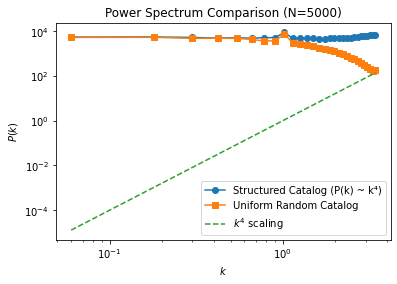

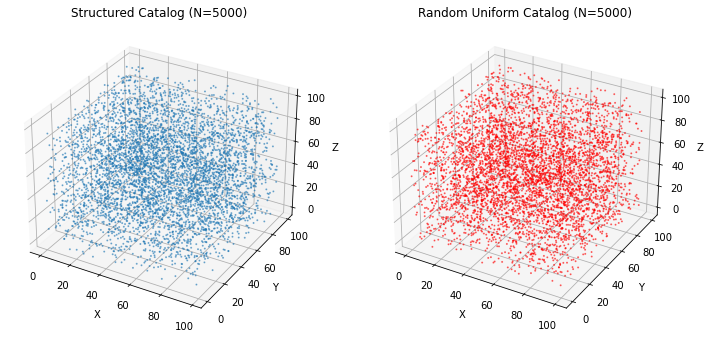

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Grid points per dimension
L = 100.0  # Box size
N_points = 5000  # Desired number of points

# Define k-space grid
k_freq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Convert to physical k
kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1  # Avoid division by zero at k=0

# Generate random phases
random_phases = np.exp(2j * np.pi * np.random.rand(N, N, N))

# Apply power-law P(k) ~ k^4  -> δ_k ~ k^2
delta_k = (k**2) * random_phases  
delta_k[k == 0] = 0  # Set mean mode to zero

# Transform back to real space
delta_x = np.fft.ifftn(delta_k).real

# Normalize the field
delta_x -= np.mean(delta_x)  # Zero mean
delta_x /= np.std(delta_x)   # Normalize variance

# **Sort voxels by density and pick N_points**
sorted_indices = np.argsort(delta_x.flatten())[::-1]  # Sort in descending order
top_indices = sorted_indices[:N_points]  # Keep only the top N_points

# Convert indices back to 3D positions
point_indices = np.column_stack(np.unravel_index(top_indices, (N, N, N)))
coords_structured = point_indices * (L / N)  # Convert to real-space coordinates

# **Generate a uniform random catalog**
coords_random = np.random.uniform(0, L, size=(N_points, 3))

# **CIC Grid Assignment**
def catalog_to_grid_cic(coords, N, L):
    grid = np.zeros((N, N, N))
    for x, y, z in coords:
        xi, yi, zi = x / (L / N), y / (L / N), z / (L / N)
        # Cloud-In-Cell (CIC) interpolation
        x0, y0, z0 = int(xi), int(yi), int(zi)
        dx, dy, dz = xi - x0, yi - y0, zi - z0
        grid[x0, y0, z0] += (1 - dx) * (1 - dy) * (1 - dz)
        grid[(x0+1)%N, y0, z0] += dx * (1 - dy) * (1 - dz)
        grid[x0, (y0+1)%N, z0] += (1 - dx) * dy * (1 - dz)
        grid[x0, y0, (z0+1)%N] += (1 - dx) * (1 - dy) * dz
        grid[(x0+1)%N, (y0+1)%N, z0] += dx * dy * (1 - dz)
        grid[(x0+1)%N, y0, (z0+1)%N] += dx * (1 - dy) * dz
        grid[x0, (y0+1)%N, (z0+1)%N] += (1 - dx) * dy * dz
        grid[(x0+1)%N, (y0+1)%N, (z0+1)%N] += dx * dy * dz
    return grid

# Assign the point distributions to the grid
density_structured = catalog_to_grid_cic(coords_structured, N, L)
density_random = catalog_to_grid_cic(coords_random, N, L)

# **Compute power spectrum**
def compute_power_spectrum(density, N):
    delta_k_fft = np.fft.fftn(density)
    Pk = np.abs(delta_k_fft)**2  # Power spectrum
    
    # Bin P(k)
    k_bins = np.linspace(0, np.max(k), 30)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    Pk_binned = np.zeros(len(k_bin_centers))
    counts = np.zeros(len(k_bin_centers))

    for i in range(N):
        for j in range(N):
            for l in range(N):
                k_val = k[i, j, l]
                bin_idx = np.digitize(k_val, k_bins) - 1
                if 0 <= bin_idx < len(Pk_binned):
                    Pk_binned[bin_idx] += Pk[i, j, l]
                    counts[bin_idx] += 1

    Pk_binned /= counts  # Normalize
    return k_bin_centers, Pk_binned

k_vals, Pk_structured = compute_power_spectrum(density_structured, N)
_, Pk_random = compute_power_spectrum(density_random, N)

# **Plot P(k) comparison**
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_vals, Pk_structured, 'o-', label="Structured Catalog (P(k) ~ k⁴)")
ax.plot(k_vals, Pk_random, 's-', label="Uniform Random Catalog")
ax.plot(k_vals, k_vals**4, '--', label=r"$k^4$ scaling")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_title(f"Power Spectrum Comparison (N={N_points})")
ax.legend()
plt.show()

# **Plot 3D scatter plots of both distributions**
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(coords_structured[:, 0], coords_structured[:, 1], coords_structured[:, 2], s=1, alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f"Structured Catalog (N={N_points})")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(coords_random[:, 0], coords_random[:, 1], coords_random[:, 2], s=1, alpha=0.5, color='r')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f"Random Uniform Catalog (N={N_points})")

plt.show()
